# Noisy GP Experiments

In [1]:
import numpy as np
import numba
import matplotlib as mpl
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import axes3d
from sklearn.utils import check_random_state, check_array, check_X_y
from sklearn.model_selection import train_test_split
from scipy.spatial.distance import pdist, cdist, squareform
from sklearn.metrics.pairwise import check_pairwise_arrays, euclidean_distances
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import _check_length_scale, WhiteKernel, RBF
from scipy import interpolate
from sklearn.metrics import mean_absolute_error, mean_squared_error
import warnings
mpl.rcParams['savefig.pad_inches'] = 0

%matplotlib inline

## 1D Toy Example

In [2]:
figure_location = '/home/emmanuel/projects/2018_igarss/figures/noisy_gp/1d_example/'


In [3]:
weights = {}
predictions = {}
variance = {}
scores = {}

### Sample Data

In [40]:
seed = 123
rng = np.random.RandomState(seed=seed)

# sample data parameters
n_train, n_test, n_trial = 60, 100, 2000
sigma_y = 0.05
x_cov = 0.8
y_scale = .5
x_min, x_max = -10, 10

# real function
f = lambda x: np.sin(1.0 * np.pi / 1.6 * np.cos(5 + y_scale * x))
# f = lambda x: np.sinc(x)
# f = lambda x: np.sin(2. * x) + np.exp(0.2 * x)


# Training add x, y = f(x)
x = np.linspace(x_min, x_max, n_train + n_test + n_trial)


x, xs, = train_test_split(x, train_size=n_train, random_state=seed)

# add noise
y = f(x)
x_train = x + x_cov * rng.randn(n_train)
y_train = f(x) + sigma_y * rng.randn(n_train)

x_train, y_train = x_train[:, np.newaxis], y_train[:, np.newaxis]



# -----------------
# Testing Data
# -----------------
xs, xt = train_test_split(xs, train_size=n_test, random_state=seed)
xt = np.sort(xt)

ys = f(xs)

# Add noise
x_test = xs + x_cov * rng.randn(n_test)
y_test = ys

x_test, y_test = x_test[:, np.newaxis], y_test[:, np.newaxis]

# -------------------
# Plot Points
# -------------------
x_plot = np.linspace(x_min, x_max, n_test)[:, None]
y_plot = f(x_plot)

/home/emmanuel/.conda/envs/sci_py36/lib/python3.6/site-packages/sklearn/model_selection/_split.py:2026: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)


In [41]:
print(x.shape, y.shape)
print(x_train.shape, y_train.shape)
print(x_test.shape, x_test.shape)

(60,) (60,)
(60, 1) (60, 1)
(100, 1) (100, 1)


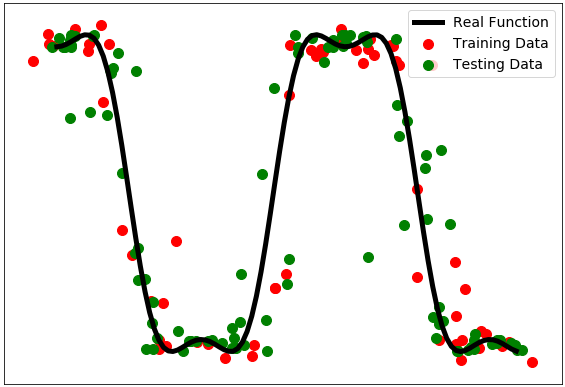

In [42]:
# plot toy data
fig, ax = plt.subplots(figsize=(10, 7))

ax.plot(x_plot, y_plot, linewidth=5, color='k', label='Real Function')
ax.scatter(x_train, y_train, color='r', s=100, label='Training Data')
ax.scatter(x_test, y_test, color='g', s=100, label='Testing Data')

# ax.set_title('Training and Testing Data', fontsize=20)
ax.legend(fontsize=14)
ax.get_xaxis().set_visible(False)
ax.get_yaxis().set_visible(False)
plt.show()

save_name = 'training_data.png'

fig.savefig(figure_location + save_name, bbox_inhces='tight',
            dpi=100, transparent=True, frameon=None)

## Naive GP Implementation (to Find Suitable Hyperparameters)

In [43]:
def fit_gp(x_train, y_train, kernel='ard', scale=None,
           length_scale_bounds = (0.001, 100),
           noise_level_bounds = (1e-4, 10),
           n_restarts=3):
    
    warnings.simplefilter('ignore')
    x_train, y_train = check_X_y(x_train, y_train)
    warnings.simplefilter('default')
    n_train, d_dims = x_train.shape
    
    if kernel in ['ard', 'ARD']:
        length_scale_init = np.ones(shape=(d_dims))
    elif kernel in ['rbf', 'RBF']:
        length_scale_init = 1.0
    else:
        raise ValueError('Unrecognized kernel function...')
    
    noise_level_init = 1.0

    gp_kernel = RBF(length_scale=length_scale_init,
                    length_scale_bounds=length_scale_bounds) + \
                WhiteKernel(noise_level=noise_level_init,
                            noise_level_bounds=noise_level_bounds)
    
    gpr_model = GaussianProcessRegressor(kernel=gp_kernel, random_state=123,
                                         n_restarts_optimizer=n_restarts)
    
    # Fit the GP Model
    gpr_model.fit(x_train, y_train)
    
    # the parameters
    length_scale = gpr_model.kernel_.k1.length_scale
    sigma = gpr_model.kernel_.k2.noise_level
    
    return length_scale, sigma

In [44]:
length_scale, sigma_y = fit_gp(x_train, y_train, n_restarts=0)
print('Length Scale: {:.3f}'.format(length_scale))
print('Sigma y: {:.3f}'.format(sigma_y))

Length Scale: 2.069
Sigma y: 0.092


## Gaussian Covariance Function (ARD/RBF Kernel)

\begin{equation}
    K(x, y) = \nu \cdot \text{exp} \left[ -\frac{1}{2} (x - y)^{\top} \cdot W^{-1} \cdot (x - y) \right]
\end{equation}

* $W^{-1}= \text{diag}\left[ w_1, w_2, \ldots, w_{D} \right]$
* $w_d = \frac{1}{\lambda_d^2}$
* $\nu$ is the signal variance parameter

In [45]:
def ard_kernel(x, y=None, length_scale=None, scale=None, weighted=None, x_cov=None):
    """The Automatic Relevance Determination Kernel.
    
    Parameters
    ----------
    x : array-like, (n_samples x n_dimensions)
        An array for the left argument for the returned kernel K(X,Y)
        
    y : array-like, optional (n_samples x n_dimensions), default = None
        The right argument for the returned kernel K(X, Y). If none, 
        K(X, X) is evaulated instead.
        
    length_scale : array (n_dimensions), default: 1.0
        The length scale of the kernel. 
        
    scale : float, default: 1.0
        The vertical scale relative to the zero mean of the process in the 
        output space.
        
    Returns
    -------
    K : array, (n_samples x n_samples)
        The kernel matrix for K(X,Y) or K(X,X)
        
    Information
    -----------
    Author : Juan Emmanuel Johnson
    
    References
    ----------
    Scikit-Learn (RBF Kernel): https://goo.gl/Sz5icv
    """
    # check if x, y have the same shape
    if y is not None:
        x, y = check_pairwise_arrays(x, y)
    
    # grab samples and dimensions
    n_samples, n_dimensions = x.shape
    
    # check length scale to be appropriate
    length_scale = _check_length_scale(x, length_scale)
        
    # get default scale value
    if scale is None:
        scale = 1.0
    
    # compute the euclidean distances
    if y is None:
        dists = pdist(x / length_scale, metric='sqeuclidean')
        
        K = np.exp(-.5 * dists)
        
        # convert from upper-triangular matrix to square matrix
        K = squareform(K)
        np.fill_diagonal(K, 1)
        
    else:
        dists = cdist(x / length_scale, y / length_scale, metric='sqeuclidean')
        
        # exponentiate the distances
        K = scale * np.exp( -0.5 * dists)
        
    return K

In [46]:
def ard_derivative(x_train, x_test, weights, length_scale, scale=None, n_der=1):
    """Derivative of the GP mean function of the ARD Kernel. This function 
    computes the derivative of the mean function that has been trained with an
    ARD kernel with respect to the testing points.
    
    Parameters
    ----------
    x_train : array-like, (n_train_samples x d_dimensions)
        The training samples used to train the weights and the length scale 
        parameters.
        
    x_test : array-like, (n_test_samples x d_dimensions)
        The test samples that will be used to compute the derivative.
        
    weights : array-like, (n_train_samples, 1)
        The weights used from the training samples
        
    length_scale : array, (d_dimensions)
        The length scale for the ARD kernel. This includes a sigma value
        for each dimension.
    
    n_der : int, default: 1, ('1', '2')
        The nth derivative for the mean GP/KRR function with the ARD kernel
        
    Returns
    -------
    derivative : array-like, (n_test_samples x d_dimensions)
        The computed derivative.
        
    Information
    -----------
    Author : Juan Emmanuel Johnson
    Email  : jemanjohnson34@gmail.com
    
    References
    ----------
    Differenting GPs:
        http://mlg.eng.cam.ac.uk/mchutchon/DifferentiatingGPs.pdf
    """
    
    # check the sizes of x_train and x_test
    err_msg = "xtrain and xtest d dimensions are not equivalent."
    np.testing.assert_equal(x_test.shape[1], x_train.shape[1], err_msg=err_msg)
    
    n_train_samples, d_dimensions = x_train.shape
    n_test_samples = x_test.shape[0]
    d_length_scale = np.shape(length_scale)
    
    length_scale = _check_length_scale(x_train, length_scale)
    
    # Make the length_scale 1 dimensional
    if np.ndim(length_scale) == 0:
        length_scale = np.array([length_scale])
    if np.ndim(weights) == 1:
        weights = weights[:, np.newaxis]

    if len(length_scale) == 1 and d_dimensions > 1:
        length_scale = length_scale * np.ones(shape=(d_dimensions))
    elif len(length_scale) != d_dimensions:
        raise ValueError('Incorrect Input for length_scale.')
    
    # check the n_samples for x_train and weights are equal
    err_msg = "Number of training samples for xtrain and weights are not equal."
    np.testing.assert_equal(x_train.shape[0], weights.shape[0], err_msg=err_msg)


    if int(n_der) == 1:
        constant_term = np.diag(- np.power(length_scale**2, -1))
    
    else:
        constant_term2 = (1 / length_scale)**2
        constant_term4 = (1 / length_scale)**4
    
    # calculate the ARD Kernel
    kernel_mat = ard_kernel(x_test, x_train, length_scale=length_scale, scale=scale)
    
    # initialize derivative matrix
    derivative = np.zeros(shape=(n_test_samples, d_dimensions))
    if int(n_der) == 1:
        for itest in range(n_test_samples):
            
            x_tilde = (x_test[itest, :] - x_train).T
            
            kernel_term = (kernel_mat[itest, :][:, np.newaxis] * weights)

            derivative[itest, :] = constant_term.dot(x_tilde).dot(kernel_term).squeeze()
            
    else:
        for itest in range(n_test_samples):
            
            x_term = np.dot(constant_term2, np.ones(shape=(n_dimensions,
                                                          n_train_samples)))
            
            x_term += np.dot(constant_term4, (x_test[itest, :] - x_train).T**2)
            
            derivative[itest, :] = np.dot(x_term, kernel_mat[itest, :] * weights).T 
            
    return derivative

### GP/KRR Manually

In [47]:
from sklearn.gaussian_process.kernels import (_check_length_scale)
from sklearn.base import BaseEstimator, RegressorMixin
from sklearn.utils import check_array, check_X_y
from sklearn.gaussian_process.kernels import _check_length_scale

class GP_Simple(BaseEstimator, RegressorMixin):
    def __init__(self, length_scale=None, sigma_y=None, scale=None, kernel='ard',
                 x_covariance=None):
        self.length_scale = length_scale
        self.sigma_y = sigma_y
        self.scale = scale
        self.kernel = kernel
        self.x_covariance = x_covariance
        
    def fit(self, x, y):
        
        # check input dimensions
        x_train, y_train = check_X_y(x, y)
        
        self.n_train, self.d_dim = x_train.shape
        
        # check if length scale and sigma y are there
        try:
            if self.length_scale.any() is None or self.sigma_y is None:            
                self.length_scale, self.sigma_y = fit_gp(x_train, y_train, n_restarts=0)
        except:
            if self.length_scale is None or self.sigma_y is None:
                self.length_scale, self.sigma_y = fit_gp(x_train, y_train, n_restarts=0)
        
            
        if self.scale is None:
            self.scale = 1.0
            
        # Calculate the training kernel (ARD)
        if self.kernel in ['rbf', 'ard']:
            K_train = ard_kernel(x_train, length_scale=self.length_scale)
        elif self.kernel in ['weighted']:
            K_train = ard_kernel_weighted(x_train, x_cov=self.x_covariance,
                                          length_scale=self.length_scale)
        else:
            raise ValueError('Unrecognized kernel function.')
        
        # add white noise kernel
        L = np.linalg.cholesky(K_train + self.sigma_y * np.eye(K_train.shape[0])) 
        
        # Calculate the weights
        weights = np.linalg.solve(L.T, np.linalg.solve(L, y_train))

        if weights.ndim == 1:
            weights = weights[:, np.newaxis]
            
        # save variables
        self.x_train = x_train
        self.y_train = y_train
        self.K_ = K_train
        self.L_ = L
        self.weights_ = weights
            
    def predict(self, x, return_variance=False):
        
        x_test = check_array(x)
        
        # Calculate the train test kernel
        if self.kernel in ['rbf', 'ard']:
            K_traintest = ard_kernel(x_test, self.x_train, length_scale=self.length_scale)
            
        elif self.kernel in ['weighted']:
            K_traintest = ard_kernel_weighted(x_test, self.x_train, x_cov=self.x_covariance,
                                              length_scale=self.length_scale)
        else:
            raise ValueError('Unrecognized kernel function.')
        
        if not return_variance:
            return K_traintest.dot(self.weights_)
        
        else:
            predictions = K_traintest.dot(self.weights_)
            
            variance = self._calculate_variance(x_test, K_traintest)
            return predictions, variance
    
    def _calculate_variance(self, x, K_traintest=None):
        
        x_test = check_array(x)
        
        K_test = np.diag(ard_kernel(x_test, length_scale=self.length_scale))
        
        if K_traintest is None:
            if self.kernel in ['rbf', 'ard']:
                K_traintest = ard_kernel(x_test, self.x_train, length_scale=self.length_scale)

            elif self.kernel in ['weighted']:
                K_traintest = ard_kernel_weighted(x_test, self.x_train, x_cov=self.x_covariance,
                                                  length_scale=self.length_scale)
            else:
                raise ValueError('Unrecognized kernel function.')
        
        v = np.linalg.solve(self.L_, K_traintest.T)
        
        return self.sigma_y + K_test - np.diag(np.dot(v.T, v))


In [48]:
# Initialize GP
gp_simple = GP_Simple(length_scale=length_scale,
                       sigma_y=sigma_y)

# Fit the model
gp_simple.fit(x_train, y_train.ravel());

# Predict
predictions['simple'],  var = gp_simple.predict(x_test, return_variance=True)

scores['simple'] = mean_absolute_error(predictions['simple'], y_test)
print('\nMAE Score: {:.5f}\n'.format(scores['simple']))
print(var.min(), var.max())


MAE Score: 0.22903

0.10265435963836944 0.13125602277965664


#### Plot Simple GP Results

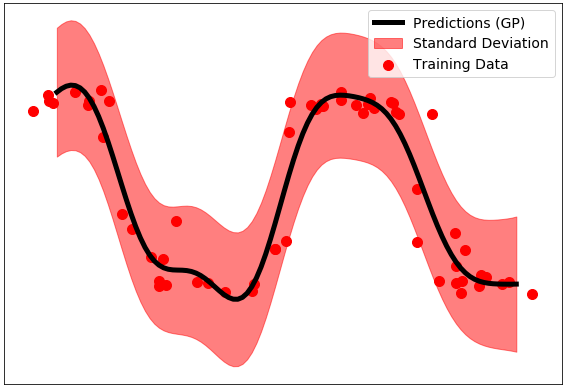

In [49]:
# Get Figure for x_plot
predictions['simple'], variance['simple'] = gp_simple.predict(x_plot, return_variance=True)


# Plot Figure

fig, ax = plt.subplots(figsize=(10, 7))

ax.plot(x_plot, predictions['simple'], linewidth=5, color='k', label='Predictions (GP)')
ax.fill_between(x_plot.squeeze(), 
                predictions['simple'].squeeze() - 2*np.sqrt(variance['simple']).squeeze(),
                predictions['simple'].squeeze() + 2*np.sqrt(variance['simple']).squeeze(), 
                color = 'red',
                alpha=0.5, label='Standard Deviation')
ax.scatter(x_train, y_train, s=100, color='r', label='Training Data')

ax.legend(fontsize=14)
ax.get_xaxis().set_visible(False)
ax.get_yaxis().set_visible(False)
ax.patch.set_visible(False)
plt.show()

save_name = 'gp_simple.png'

fig.savefig(figure_location + save_name, bbox_inhces='tight',
            dpi=100, transparent=True, frameon=None)

### Gaussian Derivative Term

\begin{align}
\frac{\partial \bar{f}_*}{\partial x_*} &= \frac{\partial k(x_*, X)}{\partial x_*} \cdot \alpha \\
 &= - \Lambda^{-1} \cdot \tilde{X}_*^{\top} \cdot \left( k(x_{*}, X)^{\top} \odot \alpha \right)
\end{align}

where:

* $\Lambda=\left[ \lambda_1, \lambda_2, \ldots, \lambda_D \right]$, the length scale
* $\tilde{X}_* = \left[ x_* - x_1, x_* - x_2, \ldots, x_* - x_N \right]^{\top} \in \mathcal{R}^{N \times D}$ 
* $\odot$ is the element-wise (hadamard) product.

In [50]:
def ard_derivative(x_train, x_test, weights, length_scale, scale=None, n_der=1):
    """Derivative of the GP mean function of the ARD Kernel. This function 
    computes the derivative of the mean function that has been trained with an
    ARD kernel with respect to the testing points.
    
    Parameters
    ----------
    x_train : array-like, (n_train_samples x d_dimensions)
        The training samples used to train the weights and the length scale 
        parameters.
        
    x_test : array-like, (n_test_samples x d_dimensions)
        The test samples that will be used to compute the derivative.
        
    weights : array-like, (n_train_samples, 1)
        The weights used from the training samples
        
    length_scale : array, (d_dimensions)
        The length scale for the ARD kernel. This includes a sigma value
        for each dimension.
    
    n_der : int, default: 1, ('1', '2')
        The nth derivative for the mean GP/KRR function with the ARD kernel
        
    Returns
    -------
    derivative : array-like, (n_test_samples x d_dimensions)
        The computed derivative.
        
    Information
    -----------
    Author : Juan Emmanuel Johnson
    Email  : jemanjohnson34@gmail.com
    
    References
    ----------
    Differenting GPs:
        http://mlg.eng.cam.ac.uk/mchutchon/DifferentiatingGPs.pdf
    """
    
    # check the sizes of x_train and x_test
    err_msg = "xtrain and xtest d dimensions are not equivalent."
    np.testing.assert_equal(x_test.shape[1], x_train.shape[1], err_msg=err_msg)
    
    n_train_samples, d_dimensions = x_train.shape
    n_test_samples = x_test.shape[0]
    d_length_scale = np.shape(length_scale)
    
    length_scale = _check_length_scale(x_train, length_scale)
    
    # Make the length_scale 1 dimensional
    if np.ndim(length_scale) == 0:
        length_scale = np.array([length_scale])
    if np.ndim(weights) == 1:
        weights = weights[:, np.newaxis]

    if len(length_scale) == 1 and d_dimensions > 1:
        length_scale = length_scale * np.ones(shape=(d_dimensions))
    elif len(length_scale) != d_dimensions:
        raise ValueError('Incorrect Input for length_scale.')
    
    # check the n_samples for x_train and weights are equal
    err_msg = "Number of training samples for xtrain and weights are not equal."
    np.testing.assert_equal(x_train.shape[0], weights.shape[0], err_msg=err_msg)


    if int(n_der) == 1:
        constant_term = np.diag(- np.power(length_scale**2, -1))
    
    else:
        constant_term2 = (1 / length_scale)**2
        constant_term4 = (1 / length_scale)**4
    
    # calculate the ARD Kernel
    kernel_mat = ard_kernel(x_test, x_train, length_scale=length_scale, scale=scale)
    
    # initialize derivative matrix
    derivative = np.zeros(shape=(n_test_samples, d_dimensions))
    if int(n_der) == 1:
        for itest in range(n_test_samples):
            
            x_tilde = (x_test[itest, :] - x_train).T
            
            kernel_term = (kernel_mat[itest, :][:, np.newaxis] * weights)

            derivative[itest, :] = constant_term.dot(x_tilde).dot(kernel_term).squeeze()
            
    else:
        for itest in range(n_test_samples):
            
            x_term = np.dot(constant_term2, np.ones(shape=(n_dimensions,
                                                          n_train_samples)))
            
            x_term += np.dot(constant_term4, (x_test[itest, :] - x_train).T**2)
            
            derivative[itest, :] = np.dot(x_term, kernel_mat[itest, :] * weights).T 
            
    return derivative

## GP w/ Derivative Term

In [51]:

class GP_Derivative(BaseEstimator, RegressorMixin):
    def __init__(self, length_scale=None, x_covariance=1.0, sigma_y=None, scale=None, 
                 variance_func='diagonal'):
        
        if isinstance(length_scale, float):
            self.length_scale = np.array([length_scale])
        
        if isinstance(x_covariance, float):
            self.x_covariance = np.asarray([x_covariance])
        self.length_scale = np.asarray(length_scale)
        self.x_covariance = np.asarray(x_covariance)
        self.sigma_y = sigma_y
        self.scale = scale
        self.variance_func = variance_func
        
    def fit(self, x, y):
        
        # check input dimensions
        x_train, y_train = check_X_y(x, y)
        
        self.n_train, self.d_dim = x_train.shape

        self.length_scale = _check_length_scale(x, self.length_scale)
        self.x_covariance = _check_length_scale(x, self.x_covariance)
        
        if np.ndim(self.x_covariance) == 0:
            self.x_covariance = np.array([self.x_covariance])
        
        # check if length scale and sigma y are there
        try:
            if self.length_scale.any() is None or self.sigma_y is None:            
                self.length_scale, self.sigma_y = fit_gp(x_train, y_train, n_restarts=0)
        except:
            if self.length_scale is None or self.sigma_y is None:
                self.length_scale, self.sigma_y = fit_gp(x_train, y_train, n_restarts=0)
        
            
        if self.scale is None:
            self.scale = 1.0
            
        # Calculate the training kernel (ARD)
        K_train = ard_kernel(x_train, length_scale=self.length_scale, scale=self.scale)
        
        # add white noise kernel and diagonal derivative term 
        L = np.linalg.cholesky(K_train + self.sigma_y * np.eye(N=self.n_train))
        
        # Calculate the weights
        weights = np.linalg.solve(L.T, np.linalg.solve(L, y_train))
        if weights.ndim == 1:
            weights = weights[:, np.newaxis]
            
        # Calculate the derivative for the training points
        if self.variance_func == 'diagonal':
            derivative = ard_derivative(x_train, x_train, 
                                        weights=weights, 
                                        length_scale=self.length_scale)
            derivative = np.diag(np.diag(
                np.dot(derivative, np.dot(np.diag(self.x_covariance), derivative.T))))
            
        elif self.variance_func == 'full':
            derivative = ard_derivative(x_train, x_train, 
                                        weights=weights, 
                                        length_scale=self.length_scale)
            
            derivative = derivative.dot(np.diag(self.x_covariance)).dot(derivative.T)
        else:
            raise ValueError('Unrecognized variance function type.')
        
        # add white noise kernel
        L_der = np.linalg.cholesky(K_train + self.sigma_y * np.eye(K_train.shape[0]) + derivative)
        
        # save variables
        self.x_train = x_train
        self.y_train = y_train
        self.K_ = K_train
        self.L_ = L
        self.derivative = derivative
        self.L_der_ = L_der
        self.weights_ = weights
        
    def predict(self, x, return_variance=False):
        
        x_test = check_array(x)
        
        # Calculate the weights
        K_traintest = ard_kernel(x_test, self.x_train,
                                 length_scale=self.length_scale)
        
        if not return_variance:
            return K_traintest.dot(self.weights_)
        
        else:
            predictions = K_traintest.dot(self.weights_)
            
            variance = self._calculate_variance(x_test, K_traintest)
            return predictions, variance
        
    
    def _calculate_derivative(self, x, y, K_train=None):
        
        # Calculate the training Kernel (ARD)
        if K_train is None:
            K_train = ard_kernel(x, length_scale=self.length_scale, scale=self.scale)

        # Calculate the weights for the initial kernel
        L = np.linalg.cholesky(K_train + self.sigma_y * np.eye(self.n_train))
        initial_weights = np.linalg.solve(L.T, np.linalg.solve(L, y))[:, np.newaxis]
        
        # Calculate the derivative  
        return ard_derivative(x, x, weights=initial_weights, length_scale=self.length_scale)

    
    def _calculate_variance(self, x, K_traintest=None):
        
        x_test = check_array(x)
        
        K_test = np.diag(ard_kernel(x_test, length_scale=self.length_scale))
        
        if K_traintest is None:
            K_traintest = ard_kernel(x_test, self.x_train, length_scale=self.length_scale)
        

        
        v = np.linalg.solve(self.L_der_, K_traintest.T)
        
        
        # calculate the derivative for the testing points
        derivative = ard_derivative(self.x_train, x_test, weights=self.weights_, 
                                    length_scale=self.length_scale)
        
        derivative = np.diag(np.dot(derivative, np.dot(np.diag(self.x_covariance), derivative.T)))
        
        return self.sigma_y + derivative + K_test - np.diag(np.dot(v.T, v))

##### Plot Derivative Term Results

In [52]:
# Initialize GP
gp_derivative_full = GP_Derivative(length_scale=length_scale,
                    sigma_y=sigma_y, variance_func='full', 
                      x_covariance=x_cov)

# Fit the model
gp_derivative_full.fit(x_train, y_train.ravel());

# Predict
predictions['derivative'],  var = gp_derivative_full.predict(x_test, return_variance=True)

scores['derivative'] = mean_absolute_error(predictions['derivative'], y_test)
print('\nMAE Score: {:.5f}\n'.format(scores['derivative']))
print(var.min(), var.max())


MAE Score: 0.22903

0.10614628922364178 0.7439577580294922


In [53]:
# Initialize GP
gp_derivative_diag = GP_Derivative(length_scale=length_scale,
                               sigma_y=sigma_y, variance_func='diagonal',
                               x_covariance=x_cov)

# Fit the model
gp_derivative_diag.fit(x_train, y_train.ravel());

# Predict
predictions['derivative_diag'],  var = gp_derivative_diag.predict(x_test, return_variance=True)

scores['derivative_diag'] = mean_absolute_error(predictions['derivative_diag'], y_test)
print('\nMAE Score: {:.5f}\n'.format(scores['derivative_diag']))
print(var.min(), var.max())


MAE Score: 0.22903

0.10858334826254401 0.6934617253473325


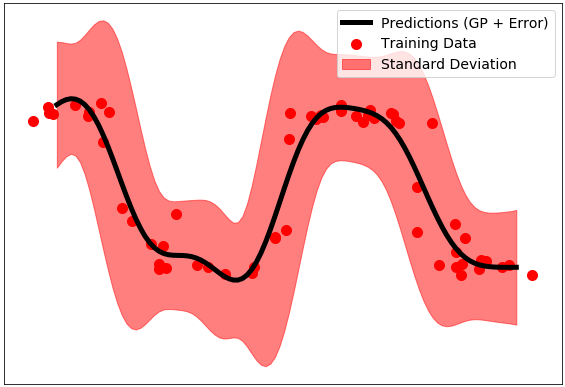

In [54]:
# Get Figure for x_plot
# gp_derivative.weights_ = gp_simple.weights_
predictions['derivative'], variance['derivative'] = gp_derivative_full.predict(x_plot, return_variance=True)


# Plot Figure

fig, ax = plt.subplots(figsize=(10, 7))

ax.plot(x_plot, predictions['derivative'], linewidth=5, color='k', label='Predictions (GP + Error)')
ax.scatter(x_train, y_train, s=100, color='r', label='Training Data')
ax.fill_between(x_plot.squeeze(), 
                predictions['derivative'].squeeze() - 2*np.sqrt(variance['derivative']).squeeze(),
                predictions['derivative'].squeeze() + 2*np.sqrt(variance['derivative']).squeeze(), 
                color = 'red',
                alpha=0.5, label='Standard Deviation')

ax.legend(fontsize=14)
ax.get_xaxis().set_visible(False)
ax.get_yaxis().set_visible(False)
ax.patch.set_visible(False)
plt.show()

save_name = 'gp_derivative.png'

fig.savefig(figure_location + save_name, bbox_inhces='tight',
            dpi=100, transparent=True, frameon=None)

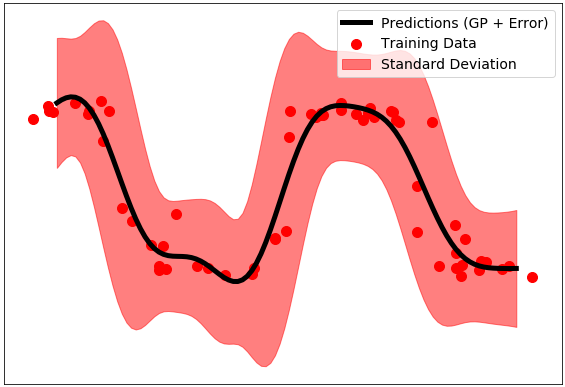

In [55]:
predictions['derivative_diag'], variance['derivative_diag'] = gp_derivative_diag.predict(x_plot, return_variance=True)


# Plot Figure

fig, ax = plt.subplots(figsize=(10, 7))

ax.plot(x_plot, predictions['derivative_diag'], linewidth=5, color='k', label='Predictions (GP + Error)')
ax.scatter(x_train, y_train, s=100, color='r', label='Training Data')
ax.fill_between(x_plot.squeeze(), 
                predictions['derivative_diag'].squeeze() - 2*np.sqrt(variance['derivative_diag']).squeeze(),
                predictions['derivative_diag'].squeeze() + 2*np.sqrt(variance['derivative_diag']).squeeze(), 
                color = 'red',
                alpha=0.5, label='Standard Deviation')

ax.legend(fontsize=14)
ax.get_xaxis().set_visible(False)
ax.get_yaxis().set_visible(False)
ax.patch.set_visible(False)
plt.show()

save_name = 'gp_derivative_diag.png'

fig.savefig(figure_location + save_name, bbox_inhces='tight',
            dpi=100, transparent=True, frameon=None)

## GP: Corrective Kernel + Derivative Term

\begin{equation}
C(u, x) = |I + W^{-1}\Sigma_x|^{-1/2} \text{exp} \left[-\frac{1}{2}(u-x)^{\top}\Delta^{-1}(u-x) \right]
\end{equation}

* $\Delta^{-1}=W^{-1}(W^{-1} + \Sigma_x^{-1})^{-1}W^{-1}$

In [56]:
def ard_kernel_weighted(x, y=None, x_cov=None, length_scale=None, scale=None):
    
    # check if x, y have the same shape
    if y is not None:
        x, y = check_pairwise_arrays(x, y)
        
    # grab samples and dimensions
    n_samples, n_dimensions = x.shape
    
    # get the default sigma values
    if length_scale is None:
        length_scale = np.ones(shape=n_dimensions)
        
    else:
        length_scale = _check_length_scale(x, length_scale)
        
    # check covariance values
    if x_cov is None:
        x_cov = 0.0
    else:
        x_cov = _check_length_scale(x, x_cov)
        
    # Add dimensions to lengthscale and x_cov
    if np.ndim(length_scale) == 0:
        length_scale = np.array([length_scale])
        
    if np.ndim(x_cov) == 0:
        x_cov = np.array([x_cov])
        
    # get default scale values
    if scale is None:
        scale = 1.0
        

    exp_scale = np.sqrt(x_cov + length_scale**2)
    
    scale_term = np.diag(x_cov * (length_scale**2)**(-1)) + np.eye(N=n_dimensions)
    scale_term = np.linalg.det(scale_term)
    scale_term = np.power(scale_term, -1/2) 
    
    if y is None:
        dists = pdist(x / exp_scale, metric='sqeuclidean')
        
        K = np.exp(- 0.5 * dists)
        
        K = squareform(K)
        
        np.fill_diagonal(K, 1)
        
        K *= scale_term
        
    else:
        
        dists = cdist(x / exp_scale, y / exp_scale, metric='sqeuclidean')
        
        K = np.exp(- 0.5 * dists)

        K *= scale_term
    
    return K

### Corrective Derivative Term

\begin{equation}
\nu(u, \Sigma_x) = \sigma^2(u) + \Sigma_{i,j=1}^{N} K_{i,j}^{-1} \cdot K(u, x_{i}) \cdot K(u, x_{j}) \cdot \left(1 - H(u, \bar{x}) \right) + \Sigma_{i,j=1}^{N} \beta_i \cdot \beta_j \cdot K(u, x_{i}) \cdot K(u, x_{j}) \cdot \left[ H(u, \bar{x}) - H(u, x_i) \cdot H(u, x_j) \right]
\end{equation}

where:

\begin{equation}
    H(u, \bar{x}) = \left| \left( \frac{W}{2} \right)^{-1} \Sigma_x + I \right|^{-1/2} \text{exp}
    \left[ \frac{1}{2}(u-\bar{x})^T \Delta^{-1} (u - \bar{x}) \right]
\end{equation}

* $\Delta^{-1} = \left( \frac{W}{2} \right)^{-1} \left[ \left( \frac{W}{2} \right)^{-1} + \Sigma_x^{-1} \right]^{-1/2} \left( \frac{W}{2} \right)^{-1}$
* $\bar{x} = \frac{x_i + x_j}{2}$

#### GP w/ Derivative Corrective Term

In [57]:
@numba.jit(nopython=True, nogil=True)
def calculate_q_numba(x_train, x_test, K, det_term, exp_scale):
    """Calculates the Q matrix used to compute the variance of the
    inputs with a noise covariance matrix. This uses numba to 
    speed up the calculations.
    
    Parameters
    ----------
    x_train : array, (n_samples x d_dimensions)
        The data used to train the weights.
    
    x_test : array, (d_dimensions)
        A vector of test points.
        
    K : array, (n_samples)
        The portion of the kernel matrix of the training points at 
        test point i, e.g. K = full_kernel_mat[:, i_test]
        
    det_term : float
        The determinant term that's in from of the exponent
        term.
        
    exp_scale : array, (d_dimensions)
        The length_scale that's used within the exponential term.
        
    Returns
    -------
    Q : array, (n_samples x n_samples)
        The Q matrix used to calculate the variance of the samples.
        
    Information
    -----------
    Author : J. Emmanuel Johnson
    Email  : jemanjohnson34@gmail.com
    Date   : 13 - 06 - 2018
    
    References
    ----------
    McHutchen et al. - Gaussian Process Training with Input Noise
    http://mlg.eng.cam.ac.uk/pub/pdf/MchRas11.pdf
    """
    n_train, d_dimensions = x_train.shape
    
    Q = np.zeros(shape=(n_train, n_train), dtype=np.float64)
    
    # Loop through the row terms
    for iterrow in range(n_train):
        
        # Calculate the row terms
        x_train_row = 0.5 * x_train[iterrow, :]  - x_test
        
        K_row = K[iterrow] * det_term
        
        # Loop through column terms
        for itercol in range(n_train):
            
            # Z Term
            z_term = x_train_row + 0.5 * x_train[itercol, :]
            
            # EXPONENTIAL TERM
            exp_term = np.exp( np.sum( z_term**2 * exp_scale) )
            
            # CONSTANT TERM
            constant_term = K_row * K[itercol] 
            
            # Q Matrix (Corrective Gaussian Kernel)
            Q[iterrow, itercol] = constant_term * exp_term
            
    return Q

In [58]:
class GP_Corrective(object):
    def __init__(self, length_scale=None, x_covariance=1.0, sigma_y=None, scale=None):
        self.length_scale = length_scale
        self.x_covariance = x_covariance
        self.sigma_y = sigma_y
        self.scale = scale
        
    def fit(self, x, y):
        
        # check input dimensions
        x_train, y_train = check_X_y(x, y)
        
        self.n_train, self.d_dim = x_train.shape
        
        
        self.length_scale = _check_length_scale(x, self.length_scale)
        self.x_covariance = _check_length_scale(x, self.x_covariance)
        
        if np.ndim(self.length_scale) == 0:
            self.length_scale = np.array([self.length_scale])
            
        if np.ndim(self.x_covariance) == 0:
            self.x_covariance = np.array([self.x_covariance])
            
        # check if length scale and sigma y are there
        try:
            if self.length_scale.any() is None or self.sigma_y is None:            
                self.length_scale, self.sigma_y = fit_gp(x_train, y_train, n_restarts=0)
        except:
            if self.length_scale is None or self.sigma_y is None:
                self.length_scale, self.sigma_y = fit_gp(x_train, y_train, n_restarts=0)
        
            
        if self.scale is None:
            self.scale = 1.0
            
        # Calculate the training Kernel (ARD)
        K_train = ard_kernel(x_train, length_scale=self.length_scale, scale=self.scale)
        
        # Calculate the derivative
        derivative = self._calculate_derivative(x_train, y_train, K_train)

        # Add white noise kernel and derivative term
        derivative_term = np.diag(np.diag(derivative.dot(np.diag(self.x_covariance)).dot(derivative.T)))
#         derivative_term = derivative.dot(np.diag(self.x_covariance)).dot(derivative.T)
        
        K_train += self.sigma_y**2 * np.eye(N=self.n_train) + derivative_term
            
        K_train_inv = np.linalg.inv(K_train)
        
        # Calculate the weights
        weights = K_train_inv.dot(y_train)
        
        # save variables
        self.x_train = x_train
        self.y_train = y_train
        self.K_ = K_train
        self.K_inv_ = K_train_inv
        self.derivative_ = derivative
        self.weights_ = weights
        
        return self
    
    def predict(self, x, return_std=False):
        
        x_test = check_array(x)
        
        # Calculate the weights
        K_traintest = ard_kernel_weighted(x_test, self.x_train, 
                                          x_cov=self.x_covariance, 
                                          length_scale=self.length_scale)
            
        if not return_std:
            return K_traintest.dot(self.weights_)
        
        else:
            predictions = K_traintest.dot(self.weights_)
            variance = self._calculate_variance(x_test, predictions=predictions)
            return predictions, variance
           
    def _calculate_derivative(self, x, y, K_train=None):
        
        # Calculate the training Kernel (ARD)
        if K_train is None:
            K_train = ard_kernel(x, length_scale=self.length_scale, scale=self.scale)

        # Calculate the weights for the initial kernel
        L = np.linalg.cholesky(K_train + self.sigma_y**2 * np.eye(self.n_train))
        initial_weights = np.linalg.solve(L.T, np.linalg.solve(L, y))[:, np.newaxis]
        self.der_weights_ = initial_weights
        
        # Calculate the derivative        
        return ard_derivative(x, x, weights=initial_weights, length_scale=self.length_scale)
    
    def _calculate_variance(self, x, predictions=None):
        
        x_test = check_array(x)
        n_test = x_test.shape[0]
        
        if predictions is None:
            predictions = self.predict(x_test, return_std=False)

        # Determinant Term
        det_term = 2 * self.x_covariance * np.power(self.length_scale, -2) + 1
        det_term = 1 / np.sqrt(np.linalg.det(np.diag(det_term)))
        
        # Exponential Term
        exp_scale = np.power(np.power(self.length_scale, 2) 
                             + 0.5 * np.power(self.length_scale, 4) 
                             * np.power(self.x_covariance, -1), -1)
                
        K = ard_kernel(self.x_train, x_test, length_scale=self.length_scale)
        
        
        variance = np.zeros(shape=(n_test))
        trace_term = variance.copy()
        q_weight_term = variance.copy()
        pred_term = variance.copy()
        
        # Loop through test points
        for itertest in range(n_test):
            
            # Calculate Q matrix
            Q = calculate_q_numba(self.x_train, x_test[itertest, :], K[:, itertest], det_term, exp_scale)
            
            # Terms
            trace_term[itertest] = float(np.trace(np.dot(self.K_inv_, Q)))
            q_weight_term[itertest] = float(self.weights_.T.dot(Q).dot(self.weights_))
            pred_term[itertest] = float(predictions[itertest]**2)
            # calculate the final predictive variance
            variance[itertest] = self.scale - trace_term[itertest] + \
                q_weight_term[itertest] - pred_term[itertest]
        
        # Negative variances due to numerical issues.
        # Set those variances to 0.
        var_negative = variance < 0
        if np.any(var_negative):
            warnings.warn("Predicted variances smaller than 0. "
                          "Setting those varinaces to 0.")
            
            variance[var_negative] = 0.0
        return variance
        

In [59]:
# Initialize GP
gp_corrective = GP_Corrective(length_scale=length_scale,
                       x_covariance=x_cov,
                       sigma_y=sigma_y)

# Fit the model
gp_corrective.fit(x_train, y_train.ravel());

# Predict
predictions['corrective'],  var = gp_corrective.predict(x_test, return_std=True)

scores['corrective'] = mean_absolute_error(predictions['corrective'], y_test)
print('\nMAE Score: {:.5f}\n'.format(scores['corrective']))
print(var.min(), var.max())


MAE Score: 0.24083

0.011152590348052382 0.3583540820915454


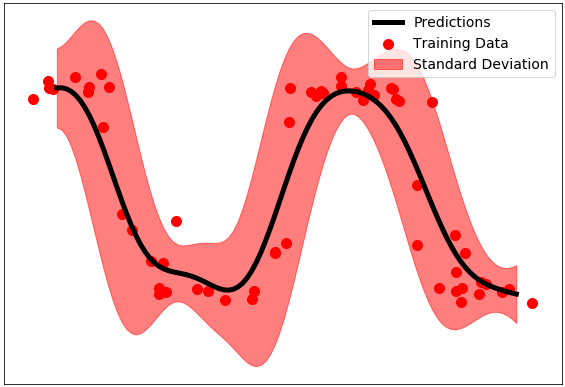

In [60]:
# Get Figure for x_plot
predictions['corrective'], variance['corrective'] = gp_corrective.predict(x_plot, return_std=True)



# Plot Figure

fig, ax = plt.subplots(figsize=(10, 7))

ax.plot(x_plot, predictions['corrective'], linewidth=5, color='k', label='Predictions')
ax.scatter(x_train, y_train, color='r', s=100, label='Training Data')
ax.fill_between(x_plot.squeeze(), 
                predictions['corrective'].squeeze() - 2*np.sqrt(variance['corrective']).squeeze(),
                predictions['corrective'].squeeze() + 2*np.sqrt(variance['corrective']).squeeze(), 
                color = 'red',
                alpha=0.5, label='Standard Deviation')

ax.legend(fontsize=14)
ax.get_xaxis().set_visible(False)
ax.get_yaxis().set_visible(False)
ax.patch.set_visible(False)
plt.show()

save_name = 'gp_corrective.png'

fig.savefig(figure_location + save_name, bbox_inhces='tight',
            dpi=100, transparent=True, frameon=None)

## Empirical Variance Comparison


### Calculate the Empirical Variance (Get Scores)

In [61]:
%%time

from sklearn.metrics import mean_absolute_error, mean_squared_error
rng = np.random.RandomState(None)
n_trials = 100

mae_score = {
    'simple': list(),
    'derivative': list(),
    'derivative_diag': list(),
    'corrective': list()
}

mse_score = {
    'simple': list(),
    'derivative': list(),
    'derivative_diag': list(),
    'corrective': list()
}

abs_error = {
    'simple': list(),
    'derivative': list(),
    'derivative_diag': list(),
    'corrective': list()
}
squared_error = {
    'simple': list(),
    'derivative': list(),
    'derivative_diag': list(),
    'corrective': list()
}

# testing set (noise-less)
ys = f(xt)
y_test = ys.squeeze()
y_test = np.atleast_2d(y_test).T

# fig, ax = plt.subplots()


for itrial in range(n_trials):
    
    # Generate x samples with random error
    x_test = xt + 0.3 * rng.randn(n_trial)
    x_test = x_test[:, np.newaxis]
    
#     ax.scatter(x_test, y_test)

    
    # -------------------
    # Model I - Simple GP
    # -------------------
    mean = gp_simple.predict(x_test, return_variance=False).squeeze()
    
    abs_error['simple'].append(np.abs(mean.squeeze() - y_test.squeeze()))
    squared_error['simple'].append((mean.squeeze() - y_test.squeeze())**2)  
    mae_score['simple'].append(mean_absolute_error(mean, y_test))
    mse_score['simple'].append(mean_squared_error(mean, y_test))
    
    # -------------------
    # Model II - Derivative GP
    # -------------------
    mean = gp_derivative_full.predict(x_test, return_variance=False).squeeze()
    
    abs_error['derivative'].append(np.abs(mean.squeeze() - y_test.squeeze()))
    squared_error['derivative'].append((mean.squeeze() - y_test.squeeze())**2)  
    mae_score['derivative'].append(mean_absolute_error(mean, y_test))
    mse_score['derivative'].append(mean_squared_error(mean, y_test))

    # -------------------
    # Model II - Derivative GP
    # -------------------
    mean = gp_derivative_diag.predict(x_test, return_variance=False).squeeze()
    
    abs_error['derivative_diag'].append(np.abs(mean.squeeze() - y_test.squeeze()))
    squared_error['derivative_diag'].append((mean.squeeze() - y_test.squeeze())**2)  
    mae_score['derivative_diag'].append(mean_absolute_error(mean, y_test))
    mse_score['derivative_diag'].append(mean_squared_error(mean, y_test))   
    # -------------------
    # Model V - GP: Corrective
    # -------------------
    mean = gp_corrective.predict(x_test, return_std=False).squeeze()
    
    abs_error['corrective'].append(np.abs(mean.squeeze() - y_test.squeeze()))
    squared_error['corrective'].append((mean.squeeze() - y_test.squeeze())**2)  
    mae_score['corrective'].append(mean_absolute_error(mean, y_test))
    mse_score['corrective'].append(mean_squared_error(mean, y_test))

#     break

# ax.scatter(x_train, y_train, label='training samples')
# ax.plot(x_plot, f(x_plot), color='black', label='real function')
# ax.legend()
# plt.show()
# Make lists into arrays
abs_error['simple'] = np.mean(np.array(abs_error['simple']).squeeze(), axis=0)
squared_error['simple'] = np.mean(np.array(squared_error['simple']).squeeze(), axis=0)
mae_score['simple'] = np.mean(np.array(mae_score['simple']))
mse_score['simple'] = np.mean(np.array(mse_score['simple']))

abs_error['derivative'] = np.mean(np.array(abs_error['derivative']).squeeze(), axis=0)
squared_error['derivative'] = np.mean(np.array(squared_error['derivative']).squeeze(), axis=0)
mae_score['derivative'] = np.mean(np.array(mae_score['derivative']))
mse_score['derivative'] = np.mean(np.array(mse_score['derivative']))

abs_error['derivative_diag'] = np.mean(np.array(abs_error['derivative_diag']).squeeze(), axis=0)
squared_error['derivative_diag'] = np.mean(np.array(squared_error['derivative_diag']).squeeze(), axis=0)
mae_score['derivative_diag'] = np.mean(np.array(mae_score['derivative_diag']))
mse_score['derivative_diag'] = np.mean(np.array(mse_score['derivative_diag']))
                       
abs_error['corrective'] = np.mean(np.array(abs_error['corrective']).squeeze(), axis=0)
squared_error['corrective'] = np.mean(np.array(squared_error['corrective']).squeeze(), axis=0)
mae_score['corrective'] = np.mean(np.array(mae_score['corrective']))
mse_score['corrective'] = np.mean(np.array(mse_score['corrective']))

CPU times: user 9.48 s, sys: 1min 44s, total: 1min 54s
Wall time: 2.39 s


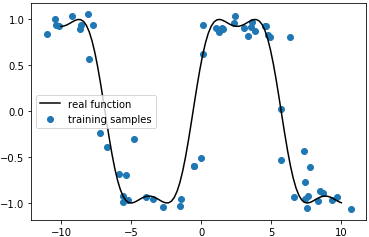

In [62]:
fig, ax = plt.subplots()

ax.scatter(x_train, y_train, label='training samples')
ax.plot(x_plot, f(x_plot), color='black', label='real function')
ax.legend()
plt.show()
# ax.scatter(xs, abs_error['simple'], color='green', label='Empirical Absolute Error (Points)')

In [33]:
print(xs.shape, abs_error['simple'].shape)

(100,) (2000,)


In [34]:
print(mse_score['simple'])

0.051286455493815


### Calculate the Variance and Standard Deviation

MSE: 0.05129
MAE: 0.16262


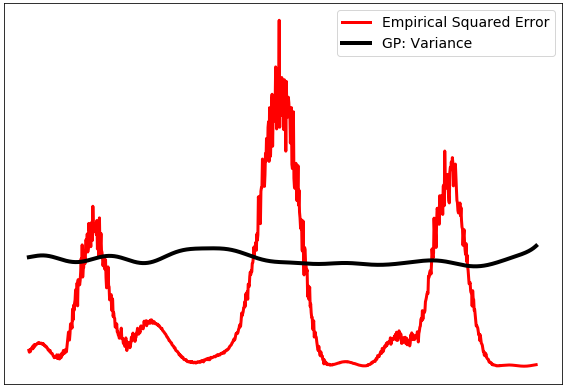

In [38]:
xnew = np.linspace(xt.min(), xt.max(), 1000)


# Interpolation function for squared error
squared_error_line = interpolate.interp1d(xt, squared_error['simple'], kind='slinear')(xnew)


print('MSE: {:.5f}'.format(mse_score['simple']))
print('MAE: {:.5f}'.format(mae_score['derivative']))

pred, var = gp_simple.predict(xt[:, np.newaxis], return_variance=True)

fig, ax = plt.subplots(nrows=1, figsize=(10, 7))

ax.plot(xnew, squared_error_line, linewidth=3, color='r', label='Empirical Squared Error')
ax.plot(xt, var, linewidth=4, color='k', label='GP: Variance')

# ax.set_title('Squared Error, Variance')
ax.grid(True)
ax.legend(fontsize=14)
ax.get_xaxis().set_visible(False)
ax.get_yaxis().set_visible(False)
plt.show()

save_name = 'exp_empirical_simple_var.png'
fig.savefig(figure_location + save_name, bbox_inhces='tight',
            dpi=100, transparent=True, frameon=None)


# abs_error_line = interpolate.interp1d(xt, abs_error['simple'], kind='quadratic')(xnew)


# fig, ax = plt.subplots(nrows=1, figsize=(10, 7))

# ax.plot(xnew, abs_error_line, linewidth=3, color='r', label='Empirical Absolute Error')
# ax.plot(x_plot, np.sqrt(variance['simple']), linewidth=4, color='k', label='GP: Standard Deviation')


# # ax.set_title('Absolute Error, Standard Deviation')
# ax.legend(fontsize=12)
# ax.grid(True)
# plt.show()

# save_name = 'exp_empirical_simple_std.png'

# fig.savefig(figure_location + save_name, bbox_inhces='tight')

MSE: 0.05129
MAE: 0.16262


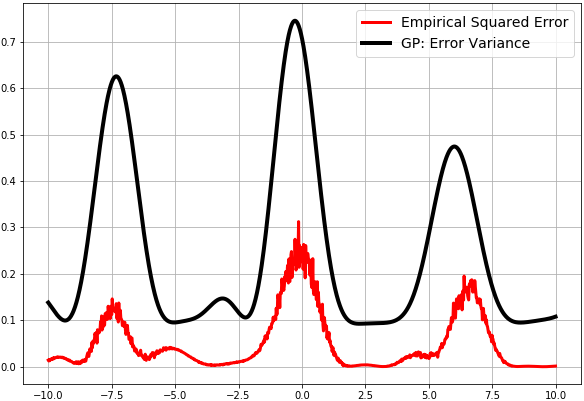

In [39]:
xnew = np.linspace(xt.min(), xt.max(), 1000)

abs_error_line = interpolate.interp1d(xt, abs_error['derivative'], kind='quadratic')(xnew)

# Interpolation function for squared error
squared_error_line = interpolate.interp1d(xt, squared_error['derivative'], kind='quadratic')(xnew)


pred, var = gp_derivative_full.predict(xt[:, np.newaxis], return_variance=True)


print('MSE: {:.5f}'.format(mse_score['derivative']))
print('MAE: {:.5f}'.format(mae_score['derivative']))


fig, ax = plt.subplots(nrows=1, figsize=(10, 7))

ax.plot(xnew, squared_error_line, linewidth=3, color='r', label='Empirical Squared Error')
ax.plot(xt, var, linewidth=4, color='k', label='GP: Error Variance')

# ax.set_title('Squared Error, Variance')
ax.legend(fontsize=14)
# ax.get_xaxis().set_visible(False)
# ax.get_yaxis().set_visible(False)
ax.grid(True)
plt.show()

# save_name = 'exp_empirical_derivative_var.png'
# fig.savefig(figure_location + save_name, bbox_inhces='tight',
#             dpi=100, transparent=True, frameon=None)


# fig, ax = plt.subplots(nrows=1, figsize=(10, 7))

# ax.plot(xnew, abs_error_line, linewidth=3, color='r', label='Empirical Absolute Error')
# ax.plot(x_plot, np.sqrt(variance['derivative']), linewidth=4, color='k', label='GP: Standard Deviation')


# # ax.set_title('Absolute Error, Standard Deviation')
# ax.legend(fontsize=12)
# ax.grid(True)
# plt.show()

# save_name = 'exp_empirical_derivative_std.png'

# fig.savefig(figure_location + save_name, bbox_inhces='tight')

MSE: 0.02332
MAE: 0.09786


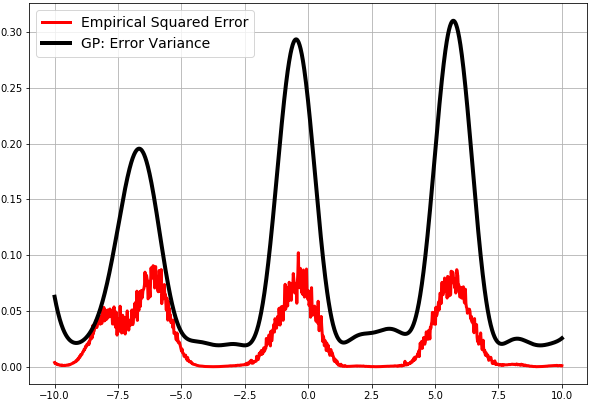

In [427]:
xnew = np.linspace(x_min, x_max, 1000)

abs_error_line = interpolate.interp1d(xt, abs_error['derivative_diag'], kind='cubic')(xnew)

# Interpolation function for squared error
squared_error_line = interpolate.interp1d(xt, squared_error['derivative_diag'], kind='slinear')(xnew)

pred, var = gp_derivative_diag.predict(xt[:, np.newaxis], return_variance=True)


print('MSE: {:.5f}'.format(mse_score['derivative_diag']))
print('MAE: {:.5f}'.format(mae_score['derivative_diag']))


fig, ax = plt.subplots(nrows=1, figsize=(10, 7))

ax.plot(xnew, squared_error_line, linewidth=3, color='r', label='Empirical Squared Error')
ax.plot(xt, var, linewidth=4, color='k', label='GP: Error Variance')

# ax.set_title('Squared Error, Variance')
ax.legend(fontsize=14)
# ax.get_xaxis().set_visible(False)
# ax.get_yaxis().set_visible(False)
ax.grid(True)
plt.show()

save_name = 'exp_empirical_derivative_diag_var.png'
fig.savefig(figure_location + save_name, bbox_inhces='tight',
            dpi=100, transparent=True, frameon=None)

MSE: 0.02708
MAE: 0.11458


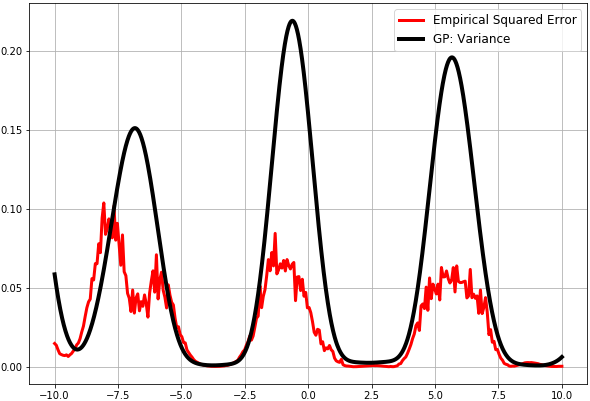

In [428]:
xnew = np.linspace(xt.min(), xt.max(), 300)

abs_error_line = interpolate.interp1d(xt, abs_error['corrective'], kind='quadratic')(xnew)

# Interpolation function for squared error
squared_error_line = interpolate.interp1d(xt, squared_error['corrective'], kind='quadratic')(xnew)

pred, var = gp_corrective.predict(xt[:, np.newaxis], return_std=True)

print('MSE: {:.5f}'.format(mse_score['corrective']))
print('MAE: {:.5f}'.format(mae_score['corrective']))

fig, ax = plt.subplots(nrows=1, figsize=(10, 7))

ax.plot(xnew, squared_error_line, linewidth=3, color='r', label='Empirical Squared Error')
ax.plot(xt, var, linewidth=4, color='k', label='GP: Variance')

# ax.set_title('Squared Error, Variance')
ax.grid(True)
ax.legend(fontsize=12)
plt.show()

save_name = 'exp_empirical_corrective_var.png'

# fig.savefig(figure_location + save_name, bbox_inhces='tight')


# fig, ax = plt.subplots(nrows=1, figsize=(10, 7))

# ax.plot(xnew, abs_error_line, linewidth=3, color='r', label='Empirical Absolute Error')
# ax.plot(x_plot, np.sqrt(variance['corrective']), linewidth=4, color='k', label='GP: Standard Deviation')


# # ax.set_title('Absolute Error, Standard Deviation')
# ax.legend(fontsize=12)
# ax.grid(True)
# plt.show()

# save_name = 'exp_empirical_corrective_std.png'

# fig.savefig(figure_location + save_name, bbox_inhces='tight')

In [276]:
xtrain = np.array([1, 5, 3])[:, np.newaxis]
xtest = np.array([1])[:, np.newaxis]
print(xtrain.shape, xtest.shape)
n_samples = xtrain.shape[0]
d_dimensions = xtrain.shape[1]

(3, 1) (1, 1)


In [216]:
xrow = xtrain[:, np.newaxis, :]
xrow = np.tile(xrow, [1, n_samples, d_dimensions])
print(xrow)
print(xrow.shape)

[[[1]
  [1]
  [1]]

 [[5]
  [5]
  [5]]

 [[3]
  [3]
  [3]]]
(3, 3, 1)


In [217]:
def zterm_matrix(xtrain):
    n_samples, d_dimensions = xtrain.shape
    
    xrow = xtrain[:, np.newaxis, :]
    xrow = np.tile(xrow, [1, n_samples, d_dimensions])
    zterm = 0.5 * (xrow + np.transpose(xrow, axes=(1,0, 2)))
    return zterm

In [94]:
xcol = xrow.copy() #xtrain[:, np.newaxis, :]
xcol = np.transpose(xcol, axes=(1,0, 2))
print(xcol)
print(xcol.shape)



[[[1]
  [5]
  [3]]

 [[1]
  [5]
  [3]]

 [[1]
  [5]
  [3]]]
(3, 3, 1)


In [95]:
zterm = 0.5 * (xrow + xcol)
zterm = zterm_matrix(xtrain)
print(zterm == zterm2)
print(zterm.shape)

NameError: name 'zterm2' is not defined

In [91]:
zterm = zterm_matrix(xtrain)
zterm = zterm - xtest
print(zterm.shape, zterm.T.shape)

(3, 3, 1) (1, 3, 3)


In [95]:
diag_term = np.array([1.0])
print(zterm.shape, diag_term.shape)
exp_term = zterm.dot(diag_term).dot(zterm.T)
print(exp_term.shape)

(3, 3, 1) (1,)
(3, 1, 3)
